In [1]:
import tsp_data_util as tsp_data_util
import tsplib95
import torch
import time
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import gc
from pso import pso
from aco import aco
import os
from statistics import mean
from tabu import tabu_search

{'func_evals': 1, 'sequence': ['city1', 'city2', 'city4', 'city3', 'city1'], 'parameters': {'tabu_list_size': 6, 'max_iterations': 1, 'worsening_threshold': 1.01}}


In [2]:
def getData(technique, problem):
    start = time.time()
    
    # runs the  problem with the technique
    result = technique(problem.edge_weights)
    end = time.time()
    
    # gets the solution
    returned_solution = result['sequence']
    
    #the time 
    runtime = end-start
    
    # memory
    """TODO: Check that memory actually works"""
    #memory = torch.cuda.memory_allocated(0)
    memory = 0
    
    #function evalauations 
    func_evals = result['func_evals']
    
    #used parameters
    params = result['parameters']

    #find proximity to optimal solution
    solution_distance = tsp_data_util.get_tour_length(problem.file, returned_solution)
    approximation_ratio = solution_distance/problem.solution_length

    return {'memory' : memory, 'closeness' : approximation_ratio, 'func_evals' : func_evals, 'runtime' : runtime}

In [3]:
def generatePlots(results):
    fig, ax = plt.subplots(nrows=1, ncols=3)

    ax[0].scatter(results['memory'], results['closeness'])
    ax[0].set_title('Memory vs. AR')
    ax[0].set_ylabel('Approximation Ratio')
    ax[0].set_xlabel('Memory')
    
    ax[1].scatter(results['func_evals'], results['closeness'])
    ax[1].set_title('Distance Checks vs. AR')
    ax[1].set_ylabel('Approximation Ratio')
    ax[1].set_xlabel('Distance Checks')
    
    ax[2].scatter(results['runtime'], results['closeness'])
    ax[2].set_title('Runtime vs. AR')
    ax[2].set_ylabel('Approximation Ratio')
    ax[2].set_xlabel('Runtime')

    fig.suptitle(results['technique'])
    fig.tight_layout()

heidelberg_TSP_data/gr96.tsp
Stopped for stagnation!
Problem Success: <function pso at 0x13a2b22a0> on heidelberg_TSP_data/gr96.tsp
heidelberg_TSP_data/p01.tsp
Stopped for stagnation!
Problem Success: <function pso at 0x13a2b22a0> on heidelberg_TSP_data/p01.tsp
heidelberg_TSP_data/bays29.tsp
Stopped for stagnation!
Problem Success: <function pso at 0x13a2b22a0> on heidelberg_TSP_data/bays29.tsp
heidelberg_TSP_data/berlin52.tsp
Stopped for stagnation!
Problem Success: <function pso at 0x13a2b22a0> on heidelberg_TSP_data/berlin52.tsp
heidelberg_TSP_data/eil51.tsp
Stopped for stagnation!
Problem Success: <function pso at 0x13a2b22a0> on heidelberg_TSP_data/eil51.tsp
heidelberg_TSP_data/ulysses16.tsp
Stopped for stagnation!
Problem Success: <function pso at 0x13a2b22a0> on heidelberg_TSP_data/ulysses16.tsp
heidelberg_TSP_data/pr76.tsp
Stopped for stagnation!
Problem Success: <function pso at 0x13a2b22a0> on heidelberg_TSP_data/pr76.tsp
heidelberg_TSP_data/gr17.tsp
Stopped for stagnation!
P

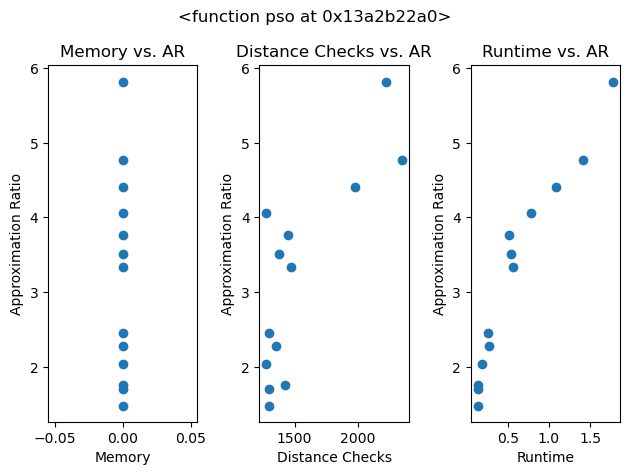

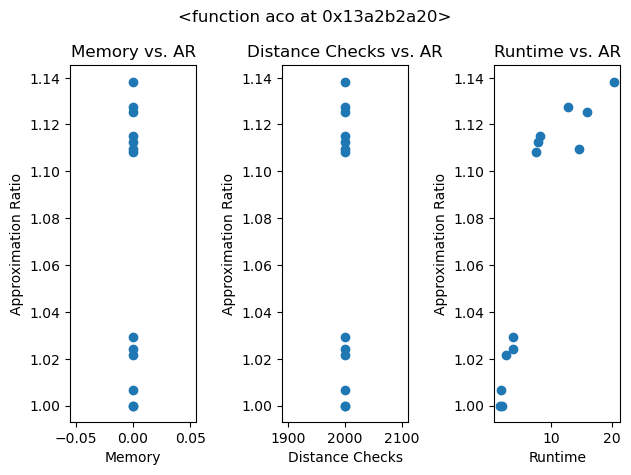

<Figure size 1000x700 with 0 Axes>

In [32]:
#collect techniques in list
techniques = [pso, aco]

#fill problems list
"""
directory = 'heidelberg_TSP_data'
problems = fill_problems(directory)
"""

# run each function on many problems to compare results
for t in techniques:
    figs = []
    # run each problem on the technique
    results = {'memory' : [], 'runtime': [], 'func_evals': [], 'closeness': []}
    for p in short_problems:
        print(p.file)
        try:
            #take data and add to list for plotting purposes
            r = getData(t,p)
            results['memory'].append(r['memory'])
            results['func_evals'].append(r['func_evals'])
            results['runtime'].append(r['runtime'])
            results['closeness'].append(r['closeness'])
            print(f'Problem Success: {t} on {p.file}')
        except:
           print(f'Problem failed: {t} on {p.file}')
           """uncomment this line to debug algorithms"""
           r = getData(t,p)

    #for each function, generate a subfigure with each plot
    results['technique'] = t
    figs.append(generatePlots(results))
    print(f'Average {t} approximation ratio: {mean(results['closeness'])}')
    
    

fig = plt.figure(figsize=(10, 7))
(figs[0]) = fig.subfigures(3, 1)
plt.show()

In [4]:
def sortedTechnique(e_matrix):
    res = torch.tensor(range(1,e_matrix.shape[0]+1))
    func_evals = 0
    params = {}
    return {'func_evals': func_evals, 'sequence': res, 'parameters':params}

In [5]:
class Problem:
    
    def __init__(self, edge_weights, solution, solution_length, tspfile):
        self.edge_weights = edge_weights
        self.solution = solution
        self.solution_length = solution_length
        self.file = tspfile

In [27]:
def fill_problems(directory):
    problems = []
    files = os.listdir(directory)
    for file in files:
        if file.endswith('.tsp'):
            print(file)
            tsp_file = directory + '/' + file
            opt_solution_tour = tsp_data_util.get_optimal_tour(tsp_file)
            if torch.is_tensor(opt_solution_tour):
                weight_matrix = tsp_data_util.generate_edge_weight_matrix(tsp_file)
                opt_solution_length = tsp_data_util.get_tour_length(tsp_file, opt_solution_tour)
                p = Problem(weight_matrix, opt_solution_tour, opt_solution_length, tsp_file)
                problems.append(p)
            else:
                continue
    return problems

problems = fill_problems('heidelberg_TSP_data')

pr439.tsp
no solution tour file exists for:  heidelberg_TSP_data/pr439.tsp  every tsp file has a opt tour length
pla7397.tsp
no solution tour file exists for:  heidelberg_TSP_data/pla7397.tsp  every tsp file has a opt tour length
gr96.tsp
rd100.tsp
swiss42.tsp
no solution tour file exists for:  heidelberg_TSP_data/swiss42.tsp  every tsp file has a opt tour length
rl5934.tsp
no solution tour file exists for:  heidelberg_TSP_data/rl5934.tsp  every tsp file has a opt tour length
pcb442.tsp
u2319.tsp
no solution tour file exists for:  heidelberg_TSP_data/u2319.tsp  every tsp file has a opt tour length
gil262.tsp
no solution tour file exists for:  heidelberg_TSP_data/gil262.tsp  every tsp file has a opt tour length
pcb3038.tsp
no solution tour file exists for:  heidelberg_TSP_data/pcb3038.tsp  every tsp file has a opt tour length
p01.tsp
brazil58.tsp
no solution tour file exists for:  heidelberg_TSP_data/brazil58.tsp  every tsp file has a opt tour length
lin105.tsp
brg180.tsp
fl417.tsp
no s

Fixes to consider:
Tabu Search:
    - Use tensors instead of arrays
    - Set defaults for all parameters but edge weights matrix
    - return best_path as a tensor
PSO:
    - returned tensor has noninteger values

In [21]:
print([problem.solution.size() for problem in problems])

[torch.Size([96]), torch.Size([100]), torch.Size([442]), torch.Size([105]), torch.Size([180]), torch.Size([225]), torch.Size([666]), torch.Size([130]), torch.Size([29]), torch.Size([52]), torch.Size([51]), torch.Size([16]), torch.Size([100]), torch.Size([202]), torch.Size([150]), torch.Size([280]), torch.Size([76]), torch.Size([17]), torch.Size([100]), torch.Size([22]), torch.Size([100]), torch.Size([76]), torch.Size([101]), torch.Size([2392]), torch.Size([48]), torch.Size([70]), torch.Size([1002]), torch.Size([561]), torch.Size([120]), torch.Size([29])]


In [22]:
allProblems = problems

In [29]:
short_problems = []
for p in problems:
    if p.solution.size()[0] < 100:
        short_problems.append(p)

In [30]:
print([problem.solution.size() for problem in short_problems])

[torch.Size([96]), torch.Size([15]), torch.Size([29]), torch.Size([52]), torch.Size([51]), torch.Size([16]), torch.Size([76]), torch.Size([17]), torch.Size([22]), torch.Size([76]), torch.Size([48]), torch.Size([70]), torch.Size([29])]
